In [1]:
repo_path = '/home/ajhnam/plinko_nn'

In [2]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.min_rows = 20
pd.options.display.max_rows = 100

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils
from plotnine import *

from torch.distributions.normal import Normal

In [3]:
device = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [4]:
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [46]:
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
collisions = collisions.sort_values(['simulation', 'run', 't'])

env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

In [96]:
idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
envs = torch.tensor(envs.values, dtype=torch.float, device=device)

In [162]:
model = MLP(input_size=[9, 4],
            hidden_layer_size=[48, 48, 48],
            activation=nn.ELU,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
epochs = 500

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

0 46.975 0.1416
100 0.886 0.6114
200 2.6501 0.5378
300 0.8349 0.6269
400 0.8331 0.6258
500 0.8316 0.6271
600 0.8547 0.6256
700 0.8474 0.6394
800 0.8407 0.6425
900 0.8381 0.6392
1000 0.8302 0.6256
1100 0.8336 0.6396
1200 0.8336 0.6287
1300 0.8316 0.6295
1400 0.8523 0.6458
1500 0.8317 0.643
1600 0.8324 0.6097
1700 0.8249 0.6249
1800 0.8329 0.6519
1900 0.8262 0.6301
2000 0.8338 0.6079



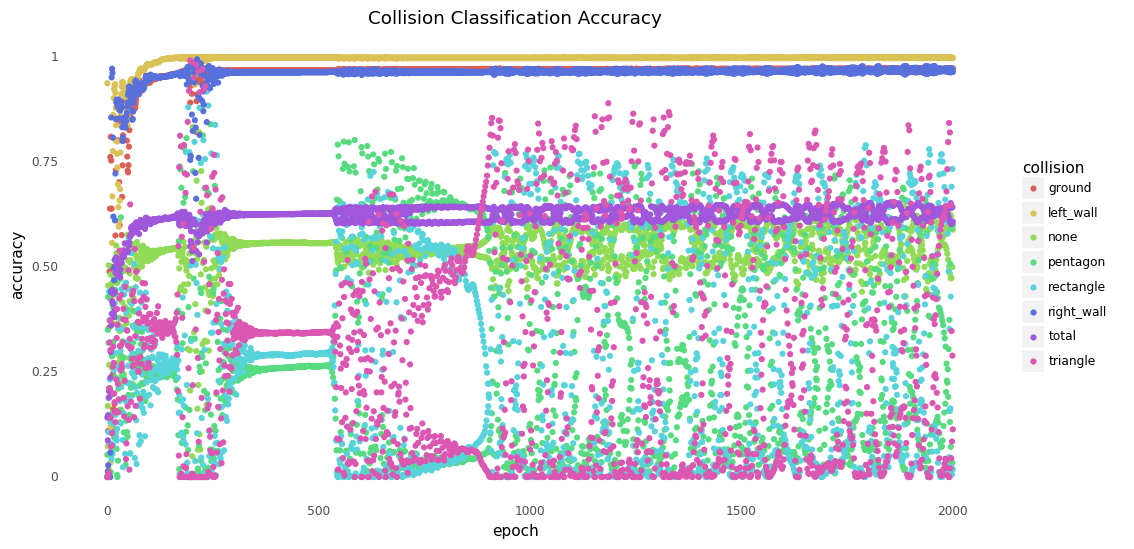

<ggplot: (8776178700953)>

In [187]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_point(aes(x='epoch', y='accuracy', color='collision'))
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)